In [1]:
import scanpy as sc
import transcriptomic_clustering as tc

In [2]:
tasic_adata = sc.read_h5ad('./data/tasic2016counts_sparse.h5ad')

# Normalize
normalized_adata = tc.normalize(tasic_adata)

# Highly Variant Genes
means, variances, gene_mask = tc.get_means_vars_genes(adata=normalized_adata)
tc.highly_variable_genes(adata=normalized_adata, 
                         means=means, variances=variances, 
                         gene_mask=gene_mask, max_genes=3000)

# PCA
(components, explained_variance_ratio, explained_variance, means) = \
    tc.pca(normalized_adata, n_comps=25, cell_select=1000, use_highly_variable=True, svd_solver='arpack')
print(components)

                     0         1         2         3         4         5   \
0610007N19Rik  0.001401  0.005660  0.000877 -0.001888 -0.005174  0.006956   
0610039K10Rik  0.000053  0.002040  0.000468  0.007206 -0.001656 -0.000511   
0610040J01Rik -0.000707  0.004878  0.000539 -0.000959 -0.002590  0.000229   
1110006O24Rik  0.000185 -0.000192  0.000693  0.000051  0.000070  0.000231   
1110015O18Rik  0.000391  0.003463  0.002330 -0.002634  0.000273 -0.000618   
...                 ...       ...       ...       ...       ...       ...   
mt_AK159262    0.011908  0.011151 -0.041511 -0.014403  0.007699  0.022651   
mt_AK166684    0.001885  0.005167 -0.003129  0.000022  0.000177  0.003803   
mt_BC006023   -0.007537  0.005603  0.010082  0.001686 -0.005659 -0.015931   
mt_BC104337    0.001058  0.004469 -0.007042 -0.000270 -0.003088  0.002556   
mt_GU332589    0.013144  0.014298 -0.014208  0.000908 -0.008194  0.013193   

                     6         7         8         9   ...        15  \
061

## Filter Known Modes

In [3]:
known_modes = components[[24]] # select last component as a known mode as an example
print(known_modes)

                     24
0610007N19Rik  0.018232
0610039K10Rik -0.001526
0610040J01Rik  0.005554
1110006O24Rik  0.002182
1110015O18Rik  0.002223
...                 ...
mt_AK159262   -0.011336
mt_AK166684    0.003595
mt_BC006023   -0.000345
mt_BC104337   -0.001462
mt_GU332589    0.006081

[3000 rows x 1 columns]


In [4]:
components = tc.filter_known_modes(components, known_modes)
print(components.shape)

(3000, 24)


## Projection

In [5]:
projected_adata = tc.project(normalized_adata, components, means)
projected_adata

/opt/anaconda3/envs/trans_clust/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1809 × 24

## Louvain Clustering

In [6]:
cluster_by_obs, obs_by_cluster, graph, qc = tc.cluster_louvain(projected_adata, 30)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11678123474121094 seconds
Jaccard graph constructed in 1.8043971061706543 seconds
Wrote graph to binary file in 0.028048038482666016 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.919924
Louvain completed 21 runs in 0.5480029582977295 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.3849050998687744 seconds


In [7]:
# REMOVE
import numpy as np
def get_cluster_means(adata, cluster_assignments):
    cluster_means = {}

    for label, idx in cluster_assignments.items():
        adata_view = adata[idx, :]
        X = adata_view.X
        cluster_means[label] = np.asarray(np.mean(X, axis=0)).ravel()

    return cluster_means

## Merging

In [8]:
#Coming soon

## Hierarchical Sorting

In [9]:
cluster_means = get_cluster_means(projected_adata, obs_by_cluster)
linkage, labels = tc.hclust(cluster_means)

In [10]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
%matplotlib inline

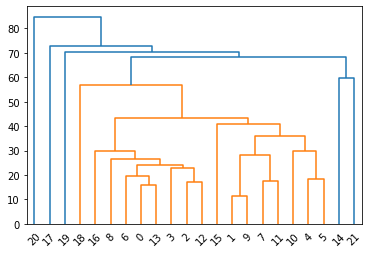

In [11]:
fig = plt.figure()
dendrogram(linkage, labels=labels)
plt.show()